## 0. Today...

- Ensemble, Advanced Model
    - Voting
    - XGBoost
    - LGBM
    - Catboost
    - Stacking

- AutoML
    - PyCaret
- Hyperparameter Tuning
    - Optuna
- Dashboard
    - Wandb

In [43]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns

- config.yml
- config.json
- config.py

In [44]:
seed = 42
np.random.seed(42)

In [45]:
BASE_DIR = './data' 

train_path = os.path.join(BASE_DIR, 'train.csv')
test_path = os.path.join(BASE_DIR, 'test.csv')
submission_path = os.path.join(BASE_DIR, 'sample_submission.csv')

print(train_path)
print(test_path)

./data/train.csv
./data/test.csv


In [46]:
train = pd.read_csv(train_path) 
test = pd.read_csv(test_path)
sample_submission = pd.read_csv(submission_path)

target = train['credit']
train.drop(['credit'], axis=1, inplace=True)

In [47]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0


In [48]:
cat_columns = [c for c, t in zip(train.dtypes.index, train.dtypes) if t=='O'] 
num_columns = [c for c in train.columns if c not in cat_columns]

print(f'Categorical Columns: \n{cat_columns}\n')
print(f'Numeric Columns: \n{num_columns}\n')

Categorical Columns: 
['gender', 'car', 'reality', 'income_type', 'edu_type', 'family_type', 'house_type', 'occyp_type']

Numeric Columns: 
['index', 'child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email', 'family_size', 'begin_month']



In [49]:
ohe_cats = []
for cat_col in cat_columns:
    ohe_cats.append(pd.get_dummies(train[cat_col], prefix=cat_col, prefix_sep='-'))

train = train.join(ohe_cats)
train.drop(cat_columns, axis=1, inplace=True)

In [50]:
ohe_cats = []
for cat_col in cat_columns:
    ohe_cats.append(pd.get_dummies(test[cat_col], prefix=cat_col, prefix_sep='-'))

test = test.join(ohe_cats)
test.drop(cat_columns, axis=1, inplace=True)

In [51]:
test = test[train.columns]

## 1. Ensemble

앙상블이란 여러 모델을 조합하거나 이를 활용하여 성능을 높이는 머신러닝 기법입니다.

경진 대회에서는 대부분 이 앙상블을 사용하여 성능을 높이는 편입니다.

앙상블을 위해서는 기본 모델의 성능이 좋아야 하고, 결론적으로는 모든 개별 모델의 성능을 높이긴 해야합니다.

또한 최후 team을 만들 때는 각자 개별 모델에서 좋은 성능을 가진 사용자끼리 합치면 좋습니다.

*일반적으로 과적합된 모델을 앙상블하면 좋다는 의견이 있습니다.*


### 1-1. Voting

- 기본적으로는 투표(voting)와 같습니다. 
    - 모델 A, 모델 B, 모델 C의 결과를 평균내는 것
    - 평균을 내는 방식은 다양함
        - 산술평균 : 일반적인 평균
            - linear regression / xgboost
            - (lr*1 + xgb*2) / 3
            - blending
        - 기하평균 : 모든 내용을 곱하고 1/n
        - 조화평균 : 역수의 산술평균 역수
        - n 제곱 후 평균 
        
    

In [15]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold

ohe = OneHotEncoder(sparse=False)
target_ohe = ohe.fit_transform(target.values.reshape(-1, 1))

# model 리스트, 입력(X), 출력(y)
def voting_model_test(model_lst, X, y):
    # A, B, C
    # [[A1, A2, A3]
    # [B1, B2, B3]
    # [C1, C2, C3]]

    valid_scores = [[] for i in range(len(model_lst))]

    # [ABC1, ABC2, ABC3]
    voting_scores = []

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=71)

    # OOF Ensemble (Out-of-Fold)
    # 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

    # tr_idx : [2, 3, 4, 5, 6, 7, 8, 9] va_idx : [0, 1]
    # tr_idx : [0, 1, 4, 5, 6, 7, 8, 9] va_idx : [2, 3]
    # tr_idx : [0, 1, 2, 3, 6, 7, 8, 9] va_idx : [4, 5]
    # tr_idx : [0, 1, 2, 3, 4, 5, 8, 9] va_idx : [6, 7]
    # tr_idx : [0, 1, 2, 3, 4, 5, 6, 7] va_idx : [8, 9]
    for tr_idx, va_idx in skf.split(X, y):
        
        X_train, X_val = X.iloc[tr_idx], X.iloc[va_idx]
        y_train, y_val = y[tr_idx], y[va_idx]
        
        preds = []

        # enumerate
        # 0, model_1
        # 1, model_2
        # 2, mode_3

        for idx, model in enumerate(model_lst):
            model.fit(X_train, y_train)
            pred = model.predict_proba(X_val)
            valid_score = log_loss(ohe.transform(y_val.reshape(-1, 1)), pred)
            valid_scores[idx].append(valid_score)
            preds.append(pred)

        # [N, 3] [N, 3] [N, 3]
        # [model_len, N, 3]
        print('total pred shape : ', np.array(preds).shape)
        pred = np.mean(preds, axis=0)
        # [N, 3]
        print('final pred shape : ', pred.shape)
        
        voting_score = log_loss(ohe.transform(y_val.reshape(-1, 1)), pred)
        print(voting_score)
        voting_scores.append(voting_score)

    return valid_scores, voting_scores

- 0.7 (0.3)
- 0.7 (0.3)
- 1 - 0.3 * 0.3 = 0.91

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

knn = KNeighborsClassifier(n_neighbors=4)
dt = DecisionTreeClassifier()
rf1 = RandomForestClassifier()
rf2 = RandomForestClassifier()
rf3 = RandomForestClassifier()

model_list = [rf1, rf2, rf3]
voting_model_test(model_list, train, target.values)

total pred shape :  (3, 5292, 3)
final pred shape :  (5292, 3)
0.7398413607200395
total pred shape :  (3, 5292, 3)
final pred shape :  (5292, 3)
0.7337746992123971
total pred shape :  (3, 5291, 3)
final pred shape :  (5291, 3)
0.7307651071806052
total pred shape :  (3, 5291, 3)
final pred shape :  (5291, 3)
0.7283379379022983
total pred shape :  (3, 5291, 3)
final pred shape :  (5291, 3)
0.7213482541101806


([[0.7959609169343699,
   0.7880397532287161,
   0.789244113753571,
   0.8189945958909383,
   0.7852079138746116],
  [0.8149601057217993,
   0.7488062433147743,
   0.7701113623945892,
   0.785333266910858,
   0.7675947737265112],
  [0.7858916068439306,
   0.7861375844143272,
   0.80061451863883,
   0.7979421692995877,
   0.7628064830326787]],
 [0.7398413607200395,
  0.7337746992123971,
  0.7307651071806052,
  0.7283379379022983,
  0.7213482541101806])

### Tips : model training

In [23]:
# 모델 테스트 및 리턴

def train_model(model_cls, # model class
                X, 
                y, 
                params={'random_state':seed}, # random seed를 포함한 다양한 파라미터
                X_test=None # 테스트 유무
               ):
    
    # model에 파라미터를 dictionary로 주는 방법
    # unpacking (dictionary unpacking)
    # 후에 json으로 hyperparameter 관리 가능
    model = model_cls(**params) 
    
    # train과 valid의 차이로 지나친 오버피팅 방지
    train_scores, valid_scores, test_result = [], [], []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

    for tr_idx, va_idx in skf.split(X, y):
        X_train, X_val = X.iloc[tr_idx], X.iloc[va_idx]
        y_train, y_val = y[tr_idx], y[va_idx]
        model.fit(X_train, y_train)
        
        pred = model.predict_proba(X_train)
        train_score = log_loss(ohe.transform(y_train.reshape(-1, 1)), pred)
        
        pred = model.predict_proba(X_val)
        valid_score = log_loss(ohe.transform(y_val.reshape(-1, 1)), pred)
        
        train_scores.append(train_score)    
        valid_scores.append(valid_score)
        
        if X_test != None:
            pred = model.predict_proba(X_test)
            test_result.append(pred)
        
    # train과 valid의 오버피팅 균형 맞추기
    print('train score mean : ',np.mean(train_scores))
    print('valid score mean : ',np.mean(valid_scores))
    return model, train_scores, valid_scores, test_result

In [24]:
train_model(RandomForestClassifier, train, target.values)

train score mean :  0.1711381966715521
valid score mean :  0.783912079715823


(RandomForestClassifier(random_state=42),
 [0.17259496838174118,
  0.17085062065358678,
  0.17113748092033346,
  0.1701964202096001,
  0.17091149319249901],
 [0.8067777093363531,
  0.779162138232269,
  0.7655281754731111,
  0.7910956201727392,
  0.7769967553646424],
 [])

### 1-2. GBM(Gradient Boosting Model)

부스팅 알고리즘은 여러 개의 약한 학습기를 순차적으로 학습하여 강한 학습기를 만든다.

여기서 대다수는 decision tree를 사용한다. (decision tree를 여러개 사용했다.)

1. 약한 학습기(dt)로 분류를 학습한다.
2. 틀리게 분류한 내용에 가중치를 부가한다.
3. 가중치를 부여한 데이터에 대해 새로운 약한 학습기를 학습을 한다. 이 경우 가중치 덕분에 이전에 틀렸던 내용에 더 집중되어 학습한다.
4. 2-3을 반복한다.
5. 이 과정에서 생긴 약한 학습기를 가중평균 하여 좋은 모델을 만든다. 여기서 가중치는 gradient descent로 학습한다.

### 1-3. GBM 종류와 라이브러리

- GBM(Gradient Boost Machine)
- AdaBoost
- XGBoost(eXtra Gradient Boost)
- LightGBM
- Catboost(Categorial GBM)

In [28]:
!pip install --upgrade pip
!pip install lightgbm xgboost catboost

     |████████████████████████████████| 1.6 MB 516 kB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 21.2.1
    Uninstalling pip-21.2.1:
      Successfully uninstalled pip-21.2.1


In [26]:
import xgboost as xgb
import lightgbm as lgbm
import catboost as cb

In [ ]:
# !pip install xgboost == 1.4.2

In [31]:
print(xgb.__version__)
print(lgbm.__version__)
print(cb.__version__)

1.4.2
3.2.1
0.26


### 1-4. XGBoost

- GBM의 단점인 느린 수행 시간 및 과적합 규제 문제 해결
    - 병렬 CPU 환경에서 병렬 학습 가능 -> 속도 개선
    - 뛰어난 예측 설명
    - 과적합 규제 
    - 나무 가지치기  
    - 자체 내장된 교차 검증 : 학습 데이터 세트와 평가 데이터 세트에 대해 교차 검증을 수행하여 최적화된 수행 횟수 가질 수 있음
    - 결손값 자체 처리


- https://sites.google.com/view/lauraepp/parameters

In [33]:
from sklearn.model_selection import train_test_split # single holdout validation

y = target.values
X = train

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgbc = xgb.XGBClassifier(nrounds=200)


xgbc.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_val, y_val)],
#          eval_metric="logloss",
        )

pred = xgbc.predict_proba(X_train)
print(log_loss(ohe.transform(y_train.reshape(-1, 1)), pred))

pred = xgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))


[11:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:31:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.97389	validation_1-mlogloss:0.97899
[1]	validation_0-mlogloss:0.90177	validation_1-mlogloss:0.91067
[2]	validation_0-mlogloss:0.85759	validation_1-mlogloss:0.87066
[3]	validation_0-mlogloss:0.82949	validation_1-mlogloss:0.84653
[4]	validation_0-mlogloss:0.80943	validation_1-mlogloss:0.83077
[5]	validation_0-mlogloss:0.79597	vali

In [34]:
xgbc.feature_importances_

array([0.01497769, 0.01663365, 0.01947633, 0.02197782, 0.02348446,
       0.        , 0.01824074, 0.02113451, 0.01855915, 0.01882299,
       0.06660278, 0.01969443, 0.        , 0.01662588, 0.        ,
       0.01705899, 0.        , 0.01670107, 0.01659153, 0.01682038,
       0.00180855, 0.01777902, 0.01053365, 0.01720679, 0.02062919,
       0.01629116, 0.01829049, 0.01881552, 0.02165976, 0.01864648,
       0.02068558, 0.01711877, 0.01636884, 0.02000763, 0.02029858,
       0.02013445, 0.030582  , 0.02086328, 0.022832  , 0.01679466,
       0.01255191, 0.01922492, 0.02152403, 0.01493263, 0.01844388,
       0.01520454, 0.01444491, 0.02866018, 0.02044371, 0.0151727 ,
       0.015182  , 0.00806158, 0.0191804 , 0.02286955, 0.01343922,
       0.02991512], dtype=float32)

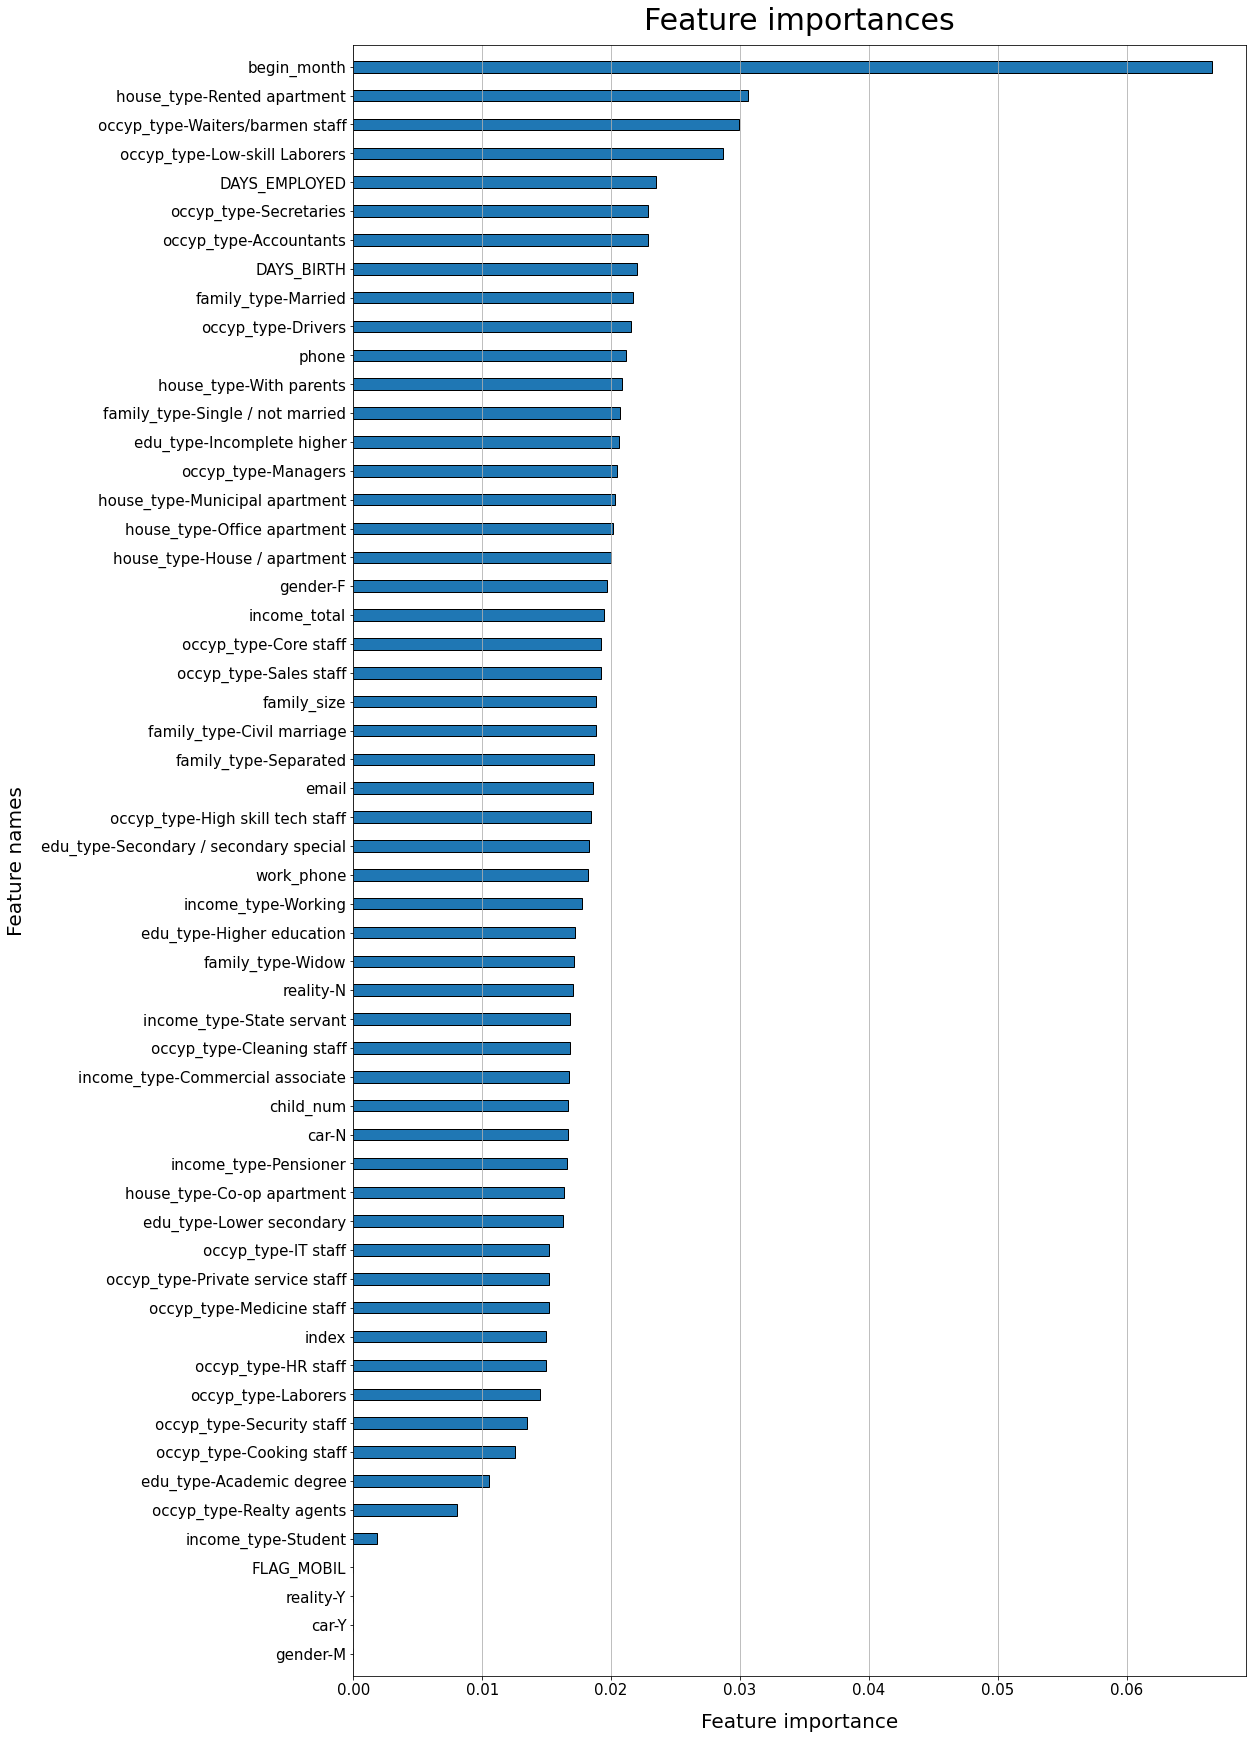

In [35]:
# 새로운 데이터 프레임 
df = pd.DataFrame(columns=["Feature", "Importance"])

# Feature에는 컬럼명 (feature 정보)
df["Feature"] = X.columns

# feature importance
df["Importance"] = xgbc.feature_importances_

# 중요도에 따라서 정렬
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

# 시각화를 위해서 피쳐개수만큼 x축 만들기
x = np.arange(0, len(df["Feature"]))
height = 0.4

# 시각화
fig, ax = plt.subplots(figsize=(16, 30))

# 범주가 많아서 한번에 보기 어려울 때 barh 사용
ax.barh(x, df["Importance"], height=height, edgecolor="black")

# 디양한 텍스트 정보
ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax.invert_yaxis()

# 시각화 테두리 여백 설정
ax.margins(0.04, 0.01)
plt.show()

In [38]:
train_copy = train.copy()
train_copy['random'] = np.random.rand(len(train))

In [39]:
train_copy['random']

0        0.111026
1        0.590671
2        0.728669
3        0.070774
4        0.022615
           ...   
26452    0.631961
26453    0.590851
26454    0.380138
26455    0.630878
26456    0.013000
Name: random, Length: 26457, dtype: float64

In [40]:
from sklearn.model_selection import train_test_split # single holdout validation



y = target.values
X = train_copy

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

xgbc = xgb.XGBClassifier(nrounds=200)

xgbc.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_val, y_val)],
#          eval_metric="logloss",
        )

pred = xgbc.predict_proba(X_train)
print(log_loss(ohe.transform(y_train.reshape(-1, 1)), pred))

pred = xgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))


[11:44:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:44:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.97390	validation_1-mlogloss:0.97913
[1]	validation_0-mlogloss:0.90153	validation_1-mlogloss:0.91083
[2]	validation_0-mlogloss:0.85673	validation_1-mlogloss:0.87035
[3]	validation_0-mlogloss:0.82875	validation_1-mlogloss:0.84602
[4]	validation_0-mlogloss:0.80948	validation_1-mlogloss:0.83052
[5]	validation_0-mlogloss:0.79641	vali

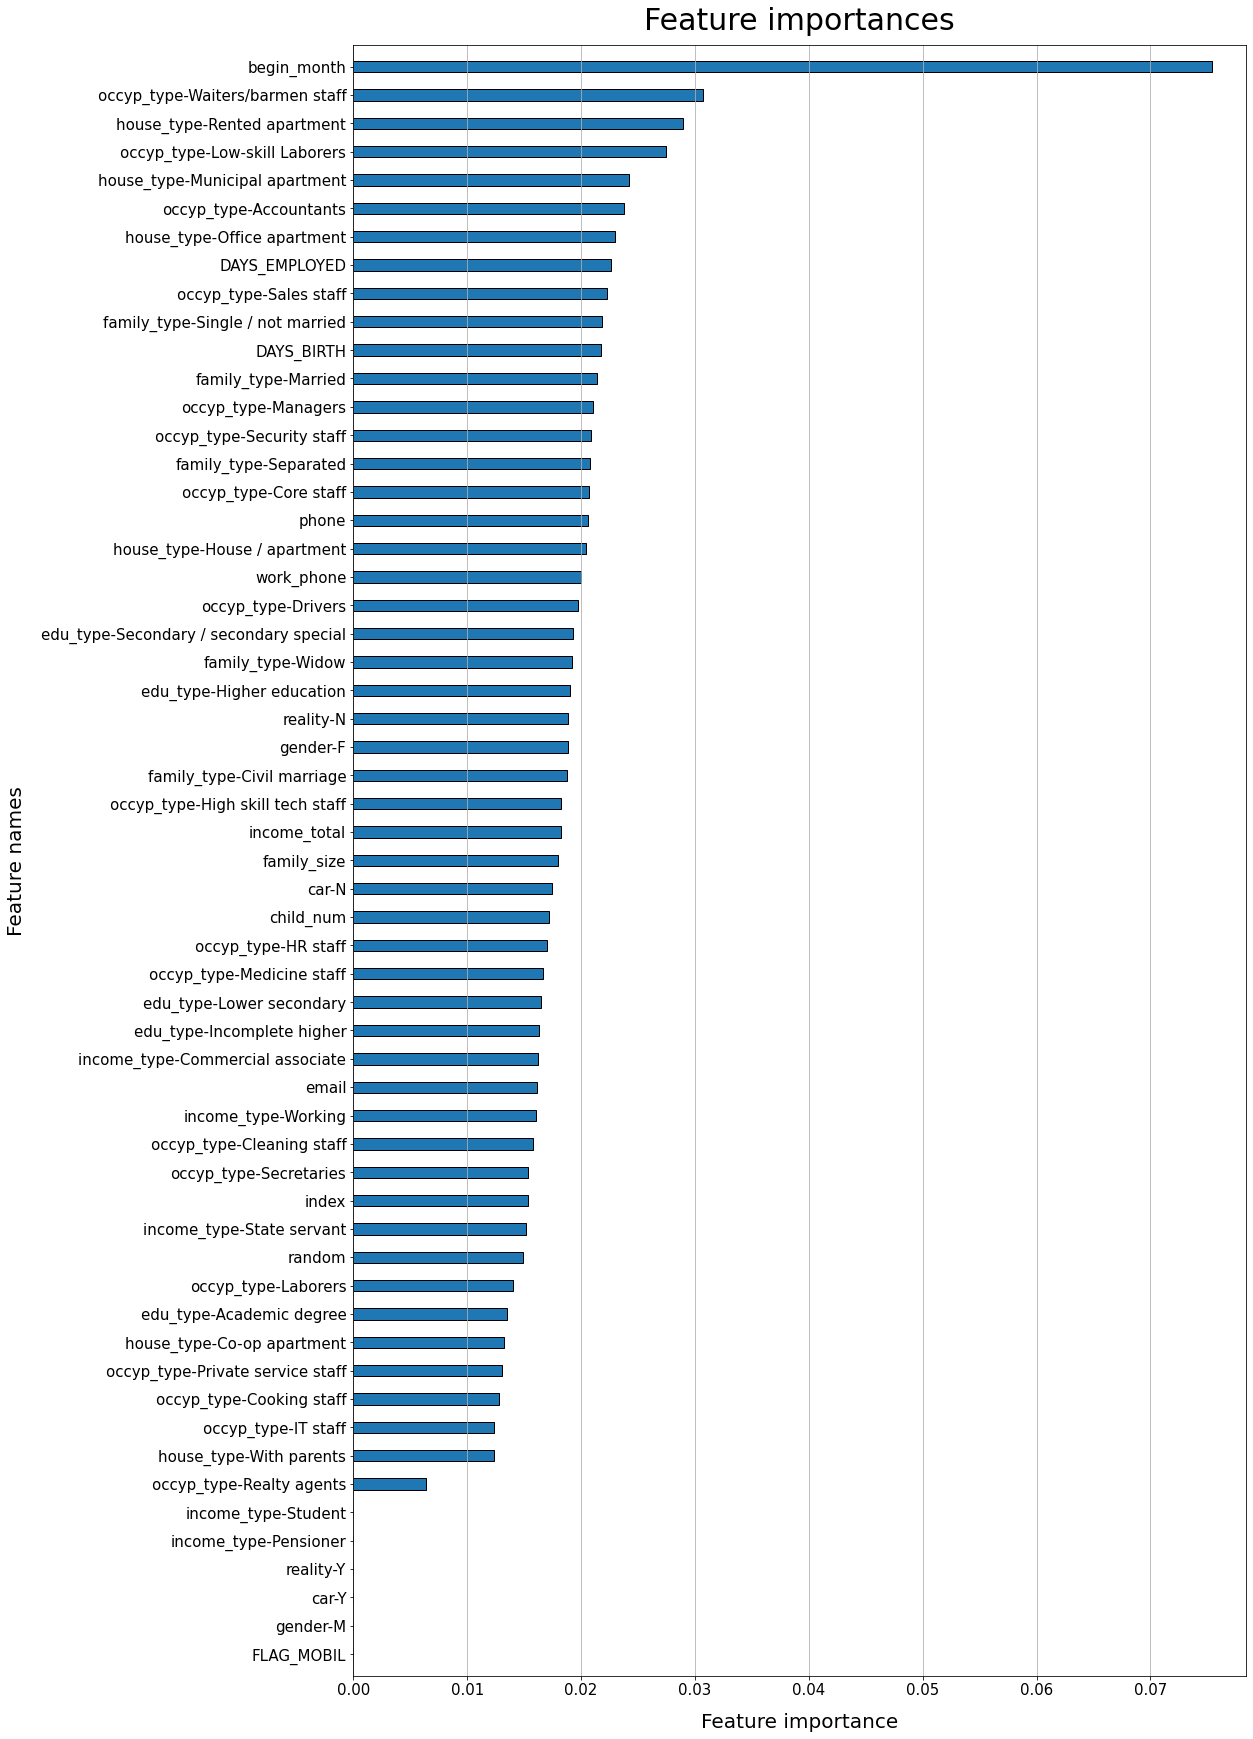

In [42]:
# 새로운 데이터 프레임 
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = X.columns
df["Importance"] = xgbc.feature_importances_
df.sort_values("Importance", axis=0, ascending=False, inplace=True)
x = np.arange(0, len(df["Feature"]))
height = 0.4
fig, ax = plt.subplots(figsize=(16, 30))
ax.barh(x, df["Importance"], height=height, edgecolor="black")
ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax.invert_yaxis()
ax.margins(0.04, 0.01)
plt.show()

Interpretable AI / Explainable AI : 해석가능한 인공지능, 설명가능한 인공지능

- https://github.com/slundberg/shap
- LIME, ELI5, .... 
- https://christophm.github.io/interpretable-ml-book/ 
    - (tootouch님 블로그)

### 1-5. LightGBM

- XGBoost도 느린데 이를 더 빠르게 개선
- 메모리 사용량도 적음
- 범주형 변수 자동 변환

In [57]:
from sklearn.model_selection import train_test_split


y = target.values
X = train

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

lgbc = lgbm.LGBMClassifier()
%time lgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])
%time xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# pred = lgbc.predict_proba(X_train)
# print(log_loss(ohe.transform(y_train.reshape(-1, 1)), pred))

# lgbm 성능
pred = lgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))

# xgb 성능
pred = xgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))


[1]	training's multi_logloss: 0.861771	valid_1's multi_logloss: 0.868191
[2]	training's multi_logloss: 0.847249	valid_1's multi_logloss: 0.856245
[3]	training's multi_logloss: 0.835397	valid_1's multi_logloss: 0.846468
[4]	training's multi_logloss: 0.826008	valid_1's multi_logloss: 0.839171
[5]	training's multi_logloss: 0.81841	valid_1's multi_logloss: 0.833441
[6]	training's multi_logloss: 0.8113	valid_1's multi_logloss: 0.828309
[7]	training's multi_logloss: 0.805557	valid_1's multi_logloss: 0.824249
[8]	training's multi_logloss: 0.800031	valid_1's multi_logloss: 0.820267
[9]	training's multi_logloss: 0.79566	valid_1's multi_logloss: 0.817731
[10]	training's multi_logloss: 0.791303	valid_1's multi_logloss: 0.814754
[11]	training's multi_logloss: 0.787503	valid_1's multi_logloss: 0.812808
[12]	training's multi_logloss: 0.784016	valid_1's multi_logloss: 0.811155
[13]	training's multi_logloss: 0.780474	valid_1's multi_logloss: 0.809129
[14]	training's multi_logloss: 0.777219	valid_1's m

In [59]:
voting_model_test([rf, lgbc, xgbc], X, y)

[13:13:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:13:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
total pred shape :  (3, 5292, 3)
final pred shape :  (5292, 3)
0.7230371493271588
[13:13:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nrounds" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but

([[0.7959609169343699,
   0.7959219147477805,
   0.7909127783581777,
   0.795582464240988,
   0.7808603335567159],
  [0.7652358938151488,
   0.7651765366035622,
   0.7675558688296537,
   0.7672918304904721,
   0.7591410117326337],
  [0.7567764910450804,
   0.756413701298356,
   0.7644449327384131,
   0.7616308361641814,
   0.7602650613308043]],
 [0.7230371493271588,
  0.726499091975239,
  0.7287399941995102,
  0.7292559134441062,
  0.7202584925067168])

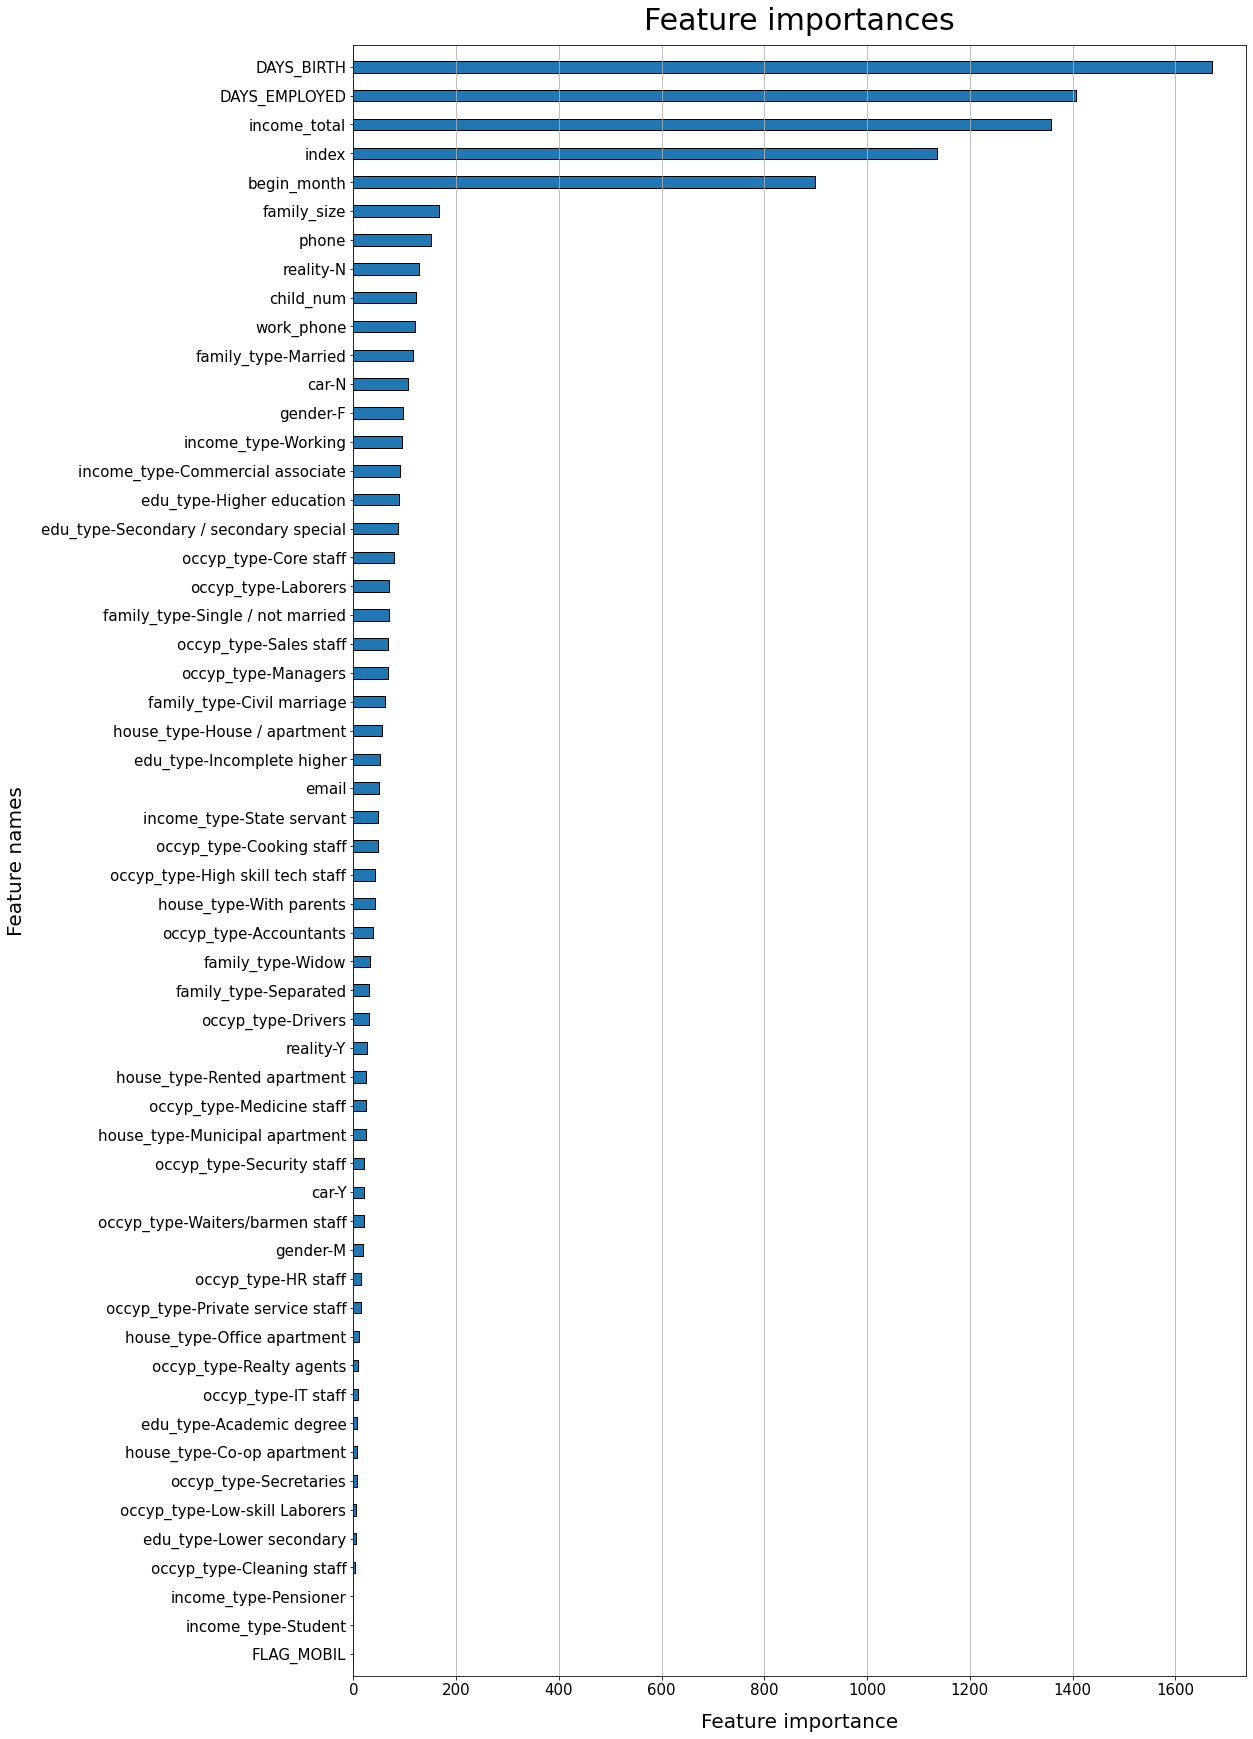

In [60]:
df = pd.DataFrame(columns=["Feature", "Importance"])
df["Feature"] = X.columns
df["Importance"] = lgbc.feature_importances_
df.sort_values("Importance", axis=0, ascending=False, inplace=True)

x = np.arange(0, len(df["Feature"]))
height = 0.4

fig, ax = plt.subplots(figsize=(16, 30))
ax.barh(x, df["Importance"], height=height, edgecolor="black")

ax.set_title("Feature importances", fontsize=30, pad=15)
ax.set_ylabel("Feature names", fontsize=20, labelpad=15)
ax.set_xlabel("Feature importance", fontsize=20, labelpad=15)
ax.set_yticks(x)
ax.set_yticklabels(df["Feature"], fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.grid(axis="x")
ax.invert_yaxis()
ax.margins(0.04, 0.01)
plt.show()

### 1-6. Catboost

- 범주형 변수에 대해 개선된 부스팅 모델
- 방법론적으로 다양하게 개선했다.
- 설명 참고 : https://dailyheumsi.tistory.com/136 

In [68]:
cbc = cb.CatBoostClassifier()
cbc.fit(X_train, y_train, 
         eval_set=[(X_train, y_train), (X_val, y_val)],
#          eval_metric="logloss",
        )

pred = cbc.predict_proba(X_train)
print(log_loss(ohe.transform(y_train.reshape(-1, 1)), pred))

pred = cbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), pred))


Learning rate set to 0.114773
0:	learn: 1.0340696	test: 1.0340696	test1: 1.0349148	best: 1.0349148 (0)	total: 122ms	remaining: 2m 1s
1:	learn: 0.9871087	test: 0.9871087	test1: 0.9885624	best: 0.9885624 (1)	total: 168ms	remaining: 1m 24s
2:	learn: 0.9509275	test: 0.9509275	test1: 0.9530339	best: 0.9530339 (2)	total: 232ms	remaining: 1m 17s
3:	learn: 0.9217029	test: 0.9217029	test1: 0.9244376	best: 0.9244376 (3)	total: 255ms	remaining: 1m 3s
4:	learn: 0.8988140	test: 0.8988140	test1: 0.9019402	best: 0.9019402 (4)	total: 272ms	remaining: 54.1s
5:	learn: 0.8808892	test: 0.8808892	test1: 0.8843743	best: 0.8843743 (5)	total: 291ms	remaining: 48.2s
6:	learn: 0.8669747	test: 0.8669747	test1: 0.8707271	best: 0.8707271 (6)	total: 305ms	remaining: 43.2s
7:	learn: 0.8551408	test: 0.8551408	test1: 0.8591519	best: 0.8591519 (7)	total: 336ms	remaining: 41.6s
8:	learn: 0.8454955	test: 0.8454955	test1: 0.8498735	best: 0.8498735 (8)	total: 385ms	remaining: 42.4s
9:	learn: 0.8383980	test: 0.8383980	test1

In [69]:
result = voting_model_test([xgb.XGBClassifier(), lgbm.LGBMClassifier(), cb.CatBoostClassifier()], 
                           train, 
                           target.values)

[13:23:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Learning rate set to 0.092455
0:	learn: 1.0462293	total: 20.5ms	remaining: 20.5s
1:	learn: 1.0059342	total: 39.5ms	remaining: 19.7s
2:	learn: 0.9731892	total: 62.8ms	remaining: 20.9s
3:	learn: 0.9455488	total: 79ms	remaining: 19.7s
4:	learn: 0.9229254	total: 94.2ms	remaining: 18.7s
5:	learn: 0.9044382	total: 112ms	remaining: 18.6s
6:	learn: 0.8895399	total: 128ms	remaining: 18.1s
7:	learn: 0.8763881	total: 145ms	remaining: 17.9s
8:	learn: 0.8653009	total: 164ms	remaining: 18.1s
9:	learn: 0.8561132	total: 181ms	remaining: 17.9s
10:	learn: 0.8483758	total: 199ms	remaining: 17.9s
11:	learn: 0.8422805	total: 210ms	remaining: 17.3s
12:	learn: 0.8365577	total: 230ms	remaining: 17.4s
13:	learn: 0.8317210	total: 260

In [70]:
print(result)

([[0.7567764910450804, 0.756413701298356, 0.7644449327384131, 0.7616308361641814, 0.7602650613308043], [0.7652358938151488, 0.7651765366035622, 0.7675558688296537, 0.7672918304904721, 0.7591410117326337], [0.7632289188026128, 0.7604217467635991, 0.7682432359054896, 0.7664533479580098, 0.7619466137370619]], [0.7522451485656128, 0.7514401114680908, 0.7570039045239233, 0.7559484068230614, 0.7514478930728823])


### 1-7. Stacking

- 개별 알고리즘의 예측 결과를 모아 예측값 데이터셋을 만든다.
    - lr : [0, 1, 2, 1, 2]
    - dt : [1, 2, 2, 1, 2]
    - rf : [0, 1, 2, 2, 1]
    - voting : [0, 1, 2, 1, 2]
    - stacking : (3, 5) => 또 다른 모델 (실제 정답)
    
- 예측값 데이터셋을 사용하여 단일 모델로 학습한다.
- 이론상으로 성능 향상을 기대할 수 있을 것 같지만 쉽지는 않다.
- 더 좋은 성능을 낼지도 무리수. 하지만 시도해볼만한 가치는 있다.

In [71]:
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
lgbc = lgbm.LGBMClassifier()
cbc = cb.CatBoostClassifier()

xgbc = xgb.XGBClassifier()

In [1]:
rf.fit(X_train, y_train)
dt.fit(X_train, y_train)
lgbc.fit(X_train, y_train)
cbc.fit(X_train, y_train)
xgbc.fit(X_train, y_train)

NameError: name 'rf' is not defined

In [ ]:
rf_pred = rf.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), rf_pred))
dt_pred = dt.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), dt_pred))
lgbc_pred = lgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), lgbc_pred))
cb_pred = cbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), cb_pred))


xgbc_pred = xgbc.predict_proba(X_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), xgbc_pred))

In [ ]:
# pred = np.array([ rf.predict(X_train), 
#                  dt.predict(X_train),
#                   lgbc.predict(X_train),
#                    cbc.predict(X_train).reshape(-1),
#                 ]).T
# print(pred.shape)

In [ ]:
pred_val = np.array([
                 rf.predict(X_val), 
                 dt.predict(X_val),
                  lgbc.predict(X_val),
                   cbc.predict(X_val).reshape(-1),
                ]).T

print(pred_val.shape)

In [ ]:
xgbc.fit(pred_val, y_val)

In [ ]:
final = xgbc.predict_proba(pred_val)
print(log_loss(ohe.transform(y_val.reshape(-1, 1)), final))

하지만 이 결과는 과적합된 결과입니다. 그렇기에 교차검증과 함께 진행하면 좋습니다.

다음 자료를 참고하면 좋습니다.

- https://dacon.io/codeshare/2594

### ETC

좋은 스태킹을 위해서는 다음 모델을 사용하라고 알려져이 있습니다.

- GBDT (2~3개)
- 신경망 (1~2개)
- 랜덤 포레스트 (1~2개)
- 선형 모델 (1개)

## 2. AutoML - PyCaret

### 2-1. PyCaret 소개

자동으로 실험을 조정하려는 시도는 다양합니다. 

PyCaret은 최근에 신흥강자로 부상한 AutoML 도구입니다.

자동으로 하기 때문에 성능이 낮을 수 있다고 생각할 수 있지만 

최근에는 다음 툴을 사용하여 국내 대회 상위권을 차지하는 경우도 다수 있었습니다.

- https://pycaret.org/

In [ ]:
!pip install pycaret

### 2-2. Pycaret Setup

setup을 통해 전체적인 시스템을 준비합니다. 

기본적으로 다음 내용을 세팅합니다.

- data
- target : target feature 명
- fold 수

In [ ]:
from pycaret.classification import *

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

setup(data = train, 
      target = 'credit',
      fold=5,
      silent = True,
     )

print('setup_compelete')

### 2-3. Metric 확인과 추가

In [ ]:
get_metrics()

기본적으로는 Logloss를 사용할 수 없습니다. 

그렇기에 logloss를 추가해주어야 합니다.

파라미터는 순서대로 

- 딕셔너리에 저장될 id, 
- DataFrame에 보여질 id,
- 실제 metric
- 정렬

In [ ]:
add_metric('logloss', 'LogLoss', log_loss, 
           greater_is_better=False, target="pred_proba")

metric을 지우고 싶다면 다음 코드를 진행하면 됩니다.

``` py
remove_metric('logloss')
```

### 2-4. 벤치마크 만들기

가장 많이 사용하는 기능 중 하나는 벤치마크를 만들 수 있는 compare_models 입니다.

다양한 모델을 한 번에 보면서 최적의 모델을 선택하는 과정이 필요합니다.

In [ ]:
best5 = compare_models(fold = 5, sort = 'logloss', n_select = 5, exclude=['svm','ridge'])

물론 이렇게 개별 모델을 만들 수도 있습니다.

다른 모델도 하나씩 만들어봅시다. (xgboost, catboost, gbc, ada) 등

### 2-6. 개별 모델 만들기와 최적화

In [ ]:
lightgbm = create_model('lightgbm')

모델 자체는 기본 모델을 사용하기 때문에 충분히 조정할 수 있는 부분이 많습니다.



In [ ]:
tuned_lightgbm = tune_model(lightgbm)

모델의 hyperparameter를 자동 튜닝하는 다양한 방법이 존재합니다.

추후에 살펴볼 optuna라는 방법도 있습니다.

In [ ]:
# !pip install optuna
import optuna
tuned_lightgbm_optuna = tune_model(lightgbm, search_library = 'optuna')

### 2-7. 결과 시각화 

- Confusion Matrix
- Loss
- Feature Importances

In [ ]:
plot_model(lightgbm, plot = 'confusion_matrix')

In [ ]:
plot_model(lightgbm, plot = 'vc')

In [ ]:
plot_model(lightgbm, plot = 'feature_all')

### 2-8. 앙상블 사용하기

blend models는 모델을 섞는 방법 중 하나입니다. voting에 가중 평균을 한다고 생각하면 됩니다.

In [ ]:
blended = blend_models(estimator_list = best5, fold = 5, optimize = 'logloss')
pred_holdout = predict_model(blended)

이 중에서 괜찮은 모델만 가져와서 따로 진행할 수도 있습니다.

In [ ]:
custom_model = compare_models(fold = 5, sort = 'logloss', n_select = 6, include=['lightgbm','gbc','rf','ada', 'lda', 'nb'])

In [ ]:
blended_custom = blend_models(estimator_list = custom_model, fold = 5, optimize = 'logloss')
pred_holdout_custom = predict_model(blended_custom)

In [ ]:
blended_custom

In [ ]:
#자동으로 상위 5개 선택한 모델
final_model = finalize_model(blended)

final_model_custom = finalize_model(blended_custom)

### 2-9. Predict Proba를 위한 추가 절차

In [ ]:
prep_pipe = get_config("prep_pipe")

In [ ]:
prep_pipe

In [ ]:
prep_pipe.steps.append(['trained_model', final_model_custom])

In [ ]:
prections = prep_pipe.predict_proba(test)
prections

해당 결과를 제출해봅시다. (15분)

### 3. Optuna

### 3-1 매개변수 조정의 방법들

매개변수를 tuning하는 방법은 많습니다.

- 수동으로 매개변수 조정
- 그리드 서치와 랜덤 서치
- 베이즈 최적화 
    - hyperopt 
    - optuna 
    - gpyopt, spearmint, scikitoptimize....

### 3-2. 매개변수 tuning 팁.

매개변수 tuning에서는 다음과 같은 사항을 결정해야 합니다.

1. 베이스라인이 될 매개변수
    - 가장 기본이 될 매개변수는 지정하고 해당 score를 확인하는 게 좋습니다.
2. 탐색 대상이 될 매개변수와 범위
    - 중요 매개변수와 일반 매개변수의 이해가 필요
3. 평가 시스템 
    - 교차 검증 + 랜덤 시드 변경 등으로 성능 체크
    
tuning에서는 다음 포인트를 주의해주세요.

- 각 알고리즘마다 핵심 매개변수와 서브 매개변수가 있습니다.
- 매개변수의 값에 따라 모델의 복잡도를 조정할 수 있습니다.
- 매개변수 범위의 상한/하한에서 결과가 좋다면 범위를 넓혀서 테스트할 수 있습니다.
- 난수 시드를 고정하여 실험을 진행합니다.
- 난수 시드를 바꿔가며 실험의 유효성을 검증합니다.

In [ ]:
from lightgbm import LGBMClassifier
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

In [ ]:
train = pd.read_csv(train_path) 
test = pd.read_csv(test_path)

train = train.drop(["index"], axis=1)
train.fillna("NAN", inplace=True)

test = test.drop(["index"], axis=1)
test.fillna("NAN", inplace=True)

In [ ]:
train_ohe = pd.get_dummies(train)
test_ohe = pd.get_dummies(test)

In [ ]:
X = train_ohe.drop(["credit"], axis=1)
y = train["credit"]
X_test = test_ohe.copy()

In [ ]:
def objective(trial):
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }
    
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_valid)
    log_score = log_loss(y_valid, lgb_pred)
    
    return log_score

In [ ]:
sampler = TPESampler(seed=42)

study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)

study.optimize(objective, n_trials=10)

print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_contour(
    study,
    params=[
        "max_depth",
        "num_leaves",
        "colsample_bytree",
        "subsample",
        "subsample_freq",
        "min_child_samples",
        "max_bin",
    ],
)

In [ ]:
optuna.visualization.plot_param_importances(study)